# <span style="color:green"><center> Gráficas de las estaciones meteorológicas </center></span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#import matplotlib.colorbar as colorbar
from matplotlib_venn import venn2
from matplotlib_scalebar.scalebar import ScaleBar
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry.point import Point

In [2]:
pcp_col = pd.read_excel('/home/fm/Downloads/pcp_col.xlsx')
#pcp_col = pcp_col.melt(id_vars = ['ID', 'X', 'Y'], var_name = 'Fecha', value_name = 'Valor').pivot_table('Valor', ['Fecha'], 'ID')
pcp_col['geometry'] = gpd.points_from_xy(pcp_col['X'], pcp_col['Y'])
gdf_pcp_col = gpd.GeoDataFrame(pcp_col[['ID', 'geometry']], geometry='geometry', crs = 'epsg:4326')
gdf_pcp_col.head()
#gdf_pcp_col = gpd.GeoDataFrame(pcp_col[['ID', 'X', 'Y']])

,ID,geometry
0,17015010,POINT (-81.70389 12.58694)
1,17025020,POINT (-81.35000 13.35000)
2,15015050,POINT (-74.22889 11.12833)
3,14015080,POINT (-75.51603 10.44725)
4,29045190,POINT (-74.77978 10.88334)


In [3]:
tmed_col = pd.read_excel('/home/fm/Downloads/tmed_col2.xlsx', sheet_name= 'tmed_col')
tmed_col['geometry'] = gpd.points_from_xy(tmed_col['X'], tmed_col['Y'])
gdf_tmed_col = gpd.GeoDataFrame(tmed_col[['ID', 'geometry']], geometry='geometry', crs = 'epsg:4326')
gdf_tmed_col.head()

,ID,geometry
0,11045010,POINT (-76.64386 5.69056)
1,11115020,POINT (-76.02972 6.75806)
2,12015020,POINT (-76.65139 7.82611)
3,12015070,POINT (-76.71783 7.81667)
4,12045020,POINT (-76.22550 9.07217)


In [4]:
gdf_pcp_tmed  = gdf_pcp_col.merge(gdf_tmed_col, how="outer", on='geometry', indicator=True)
gdf_pcp_tmed['met'] = np.where(gdf_pcp_tmed['_merge'] == 'left_only', 'precipitación', np.where(gdf_pcp_tmed['_merge'] == 'both', 'precipitación y temperatura', 'temperatura'))
gdf_pcp_tmed.groupby('met')['met'].count()

met
precipitación                  648
precipitación y temperatura    198
temperatura                     10
Name: met, dtype: int64

In [5]:
gdf_pcp_tmed['geometry'].nunique()

856

In [6]:
gdf_pcp_col.dtypes

ID             int64
geometry    geometry
dtype: object

In [7]:
# https://geoportal.igac.gov.co/contenido/datos-abiertos-cartografia-y-geografia
shp_depto = gpd.read_file('Departamentos202208_shp/Depto.shp')
shp_depto_4326 = shp_depto.to_crs("EPSG:4326")
shp_depto_4326["perimetro"] = shp_depto_4326.boundary

In [8]:
outer = sjoin(gdf_pcp_tmed, shp_depto_4326, how = 'left')
outer = outer[pd.isna(outer['perimetro'])]
outer

,ID_x,geometry,ID_y,_merge,met,index_right,DeCodigo,DeNombre,DeArea,DeNorma,SHAPE_Leng,SHAPE_Area,perimetro
1,17025020.0,POINT (-81.35000 13.35000),17025020.0,both,precipitación y temperatura,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
37,29040230.0,POINT (-74.96967 10.98833),NaN,left_only,precipitación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
90,15075030.0,POINT (-72.48017 11.78106),15075030.0,both,precipitación y temperatura,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
190,37050010.0,POINT (-71.41972 7.03722),NaN,left_only,precipitación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
591,38027020.0,POINT (-67.83417 4.95694),NaN,left_only,precipitación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
625,47030020.0,POINT (-75.62972 0.04694),NaN,left_only,precipitación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
635,47040020.0,POINT (-74.38667 -0.55917),NaN,left_only,precipitación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [9]:
shp_join_gdf = sjoin(gdf_pcp_tmed, shp_depto_4326)
#shp_join_gdf.head()

In [10]:
color_dict = {'precipitación':'blue', 'precipitación y temperatura':'orange',
              'temperatura':'red'}
color_dict2 = {'precipitación':'blue', 'precipitación y temperatura':'orange'}

In [11]:
# https://stackoverflow.com/questions/58088841/how-to-add-a-north-arrow-on-a-geopandas-map
points = gpd.GeoSeries([Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(32619) # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])
x, y, arrow_length = 0.1, 0.85, 0.1

In [12]:
shp_join_gdf['Depto'] = shp_join_gdf['DeNombre']
shp_join_gdf = shp_join_gdf.set_index("Depto")
shp_depto_4326['Depto'] = shp_depto_4326['DeNombre']
shp_depto_4326 = shp_depto_4326.set_index("DeNombre")

In [13]:
# https://geoportal.igac.gov.co/contenido/datos-abiertos-cartografia-y-geografia
shp_mun = gpd.read_file('Municipios202208_shp/Munpio.shp') 
shp_mun_4326 = shp_mun.to_crs("EPSG:4326")
shp_mun_4326["perimetro"] = shp_mun_4326.boundary
#shp_mun_4326 = shp_mun_4326.set_index("DeNombre")

In [14]:
SAyP = shp_mun_4326.query("Depto == 'San Andrés y Providencia'")
#SAyP_stations = shp_join_pcp.loc["San Andrés Providencia y Santa Catalina", "geometry"]
SAyP_stations = gpd.GeoDataFrame(shp_join_gdf.query("DeCodigo == '88'"), geometry='geometry', crs = 'epsg:4326')
color_dict3 = {'precipitación y temperatura':'orange'}
x, y, arrow_length = 0.1, 0.85, 0.1

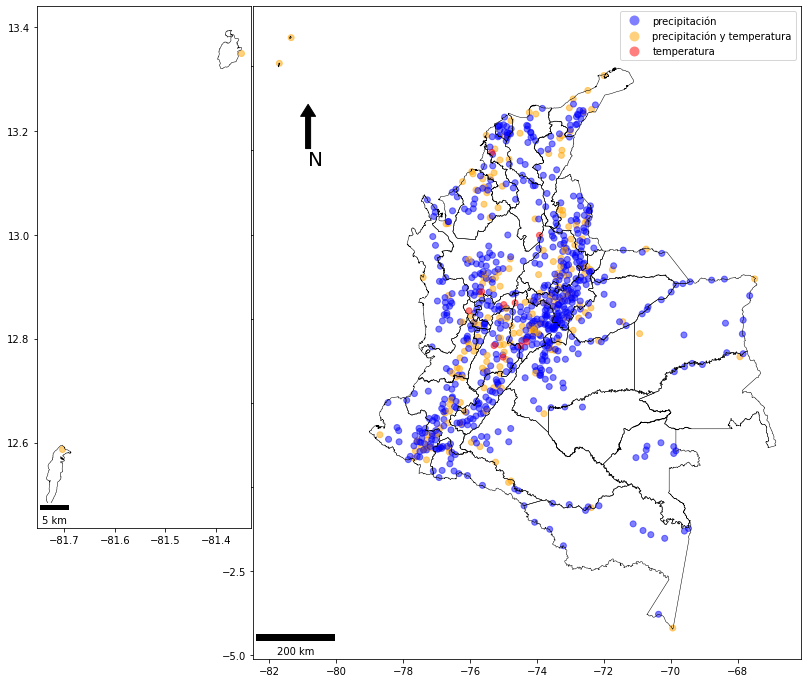

In [15]:
axis = shp_depto_4326["perimetro"].plot(color = "black",figsize = (20, 12), linewidth = 0.5)
axis.add_artist(ScaleBar(distance_meters, location='lower left'))
axis.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
              arrowprops=dict(facecolor='black', width=5, headwidth=15),
              ha='left', va='bottom', fontsize=20,
              xycoords=axis.transAxes)
shp_join_gdf.plot(ax = axis, column = 'met', alpha = 0.5, legend = True, cmap=colors.ListedColormap(list(color_dict.values()))) 
#outer.plot(ax = axis, color = 'black')
#outer.plot(ax = axis, column = 'met', cmap=colors.ListedColormap(list(color_dict2.values())))
outer.plot(ax = axis, column = 'met', alpha = 0.5, cmap=colors.ListedColormap(list(color_dict2.values())))
ins = axis.inset_axes([-0.6,0.2,0.8,0.8])
SAyP['perimetro'].plot(ax = ins, color = "black",figsize = (20, 12), linewidth = 0.5)
SAyP_stations.plot(ax = ins, column = 'met', alpha = 0.5, cmap=colors.ListedColormap(list(color_dict3.values())))
outer[outer['ID_x']== 17025020].plot(ax = ins, column = 'met', alpha = 0.5, cmap=colors.ListedColormap(list(color_dict3.values())))
ins.add_artist(ScaleBar(distance_meters, location='lower left'))
plt.show()

In [16]:
Cundi = shp_mun_4326.query("Depto == 'Cundinamarca'")
Cundi_stations = shp_join_gdf.loc["Cundinamarca", ["geometry", "met"]]

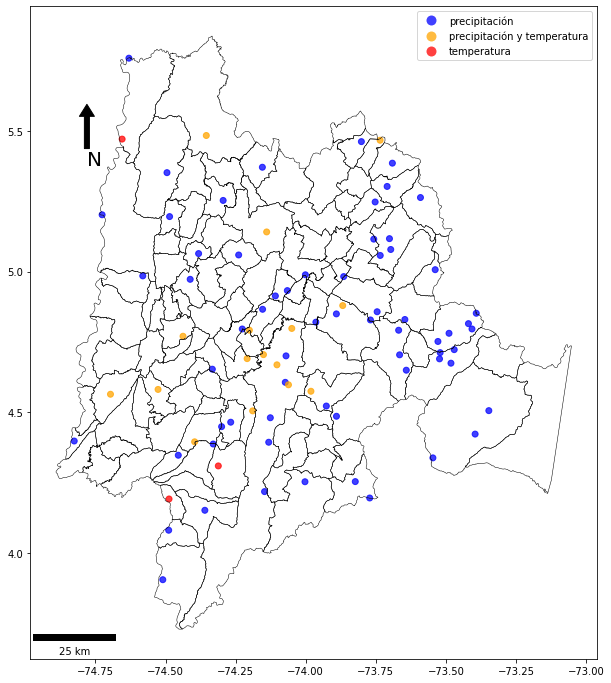

In [17]:
axis = Cundi['perimetro'].plot(color = "black",figsize = (20, 12), linewidth = 0.5)
axis.add_artist(ScaleBar(distance_meters, location='lower left'))
axis.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
              arrowprops=dict(facecolor='black', width=5, headwidth=15),
              ha='left', va='bottom', fontsize=20,
              xycoords=axis.transAxes)
Cundi_stations.plot(ax = axis, alpha = 0.75, column = 'met', legend = True, cmap=colors.ListedColormap(list(color_dict.values())))
plt.show()

In [18]:
shp_join_gdf2 = shp_join_gdf.merge(outer[['ID_x', 'geometry', 'ID_y', '_merge', 'met']], how="outer", on=['ID_x', 'geometry', 'ID_y', '_merge', 'met']) # , indicator=True
#shp_join_gdf2 = sjoin(shp_join_gdf.drop('index_right', axis=1),outer.drop('index_right', axis=1), how = 'left')

In [19]:
shp_join_gdf2.loc[shp_join_gdf2['ID_x']==17025020,'DeNombre'] = 'San Andrés Providencia y Santa Catalina'
shp_join_gdf2.loc[shp_join_gdf2['ID_x']==29040230, 'DeNombre'] = 'Atlántico'
shp_join_gdf2.loc[shp_join_gdf2['ID_x']==15075030, 'DeNombre'] = 'La Guajira'
shp_join_gdf2.loc[shp_join_gdf2['ID_x']==37050010, 'DeNombre'] = 'Arauca'
shp_join_gdf2.loc[shp_join_gdf2['ID_x']==38027020, 'DeNombre'] = 'Vichada'
shp_join_gdf2.loc[shp_join_gdf2['ID_x']==47030020, 'DeNombre'] = 'Putumayo'
shp_join_gdf2.loc[shp_join_gdf2['ID_x']==47040020, 'DeNombre'] = 'Amazonas'
shp_join_gdf2.loc[shp_join_gdf2['DeNombre']=='Area en Litigio Cauca - Huila', 'DeNombre'] = 'Cauca'

In [20]:
shp_join_gdf2.tail(7)
#shp_join_gdf2['ID_x'] = np.where(shp_join_gdf2['ID_x'] is None, shp_join_gdf2['ID_y'], shp_join_gdf2['ID_x']) #.group_by()[]

,ID_x,geometry,ID_y,_merge,met,index_right,DeCodigo,DeNombre,DeArea,DeNorma,SHAPE_Leng,SHAPE_Area,perimetro
849,17025020.0,POINT (-81.35000 13.35000),17025020.0,both,precipitación y temperatura,NaN,NaN,San Andrés Providencia y Santa Catalina,NaN,NaN,NaN,NaN,None
850,29040230.0,POINT (-74.96967 10.98833),NaN,left_only,precipitación,NaN,NaN,Atlántico,NaN,NaN,NaN,NaN,None
851,15075030.0,POINT (-72.48017 11.78106),15075030.0,both,precipitación y temperatura,NaN,NaN,La Guajira,NaN,NaN,NaN,NaN,None
852,37050010.0,POINT (-71.41972 7.03722),NaN,left_only,precipitación,NaN,NaN,Arauca,NaN,NaN,NaN,NaN,None
853,38027020.0,POINT (-67.83417 4.95694),NaN,left_only,precipitación,NaN,NaN,Vichada,NaN,NaN,NaN,NaN,None
854,47030020.0,POINT (-75.62972 0.04694),NaN,left_only,precipitación,NaN,NaN,Putumayo,NaN,NaN,NaN,NaN,None
855,47040020.0,POINT (-74.38667 -0.55917),NaN,left_only,precipitación,NaN,NaN,Amazonas,NaN,NaN,NaN,NaN,None


In [21]:
shp_join_gdf2[shp_join_gdf2['ID_x'].isin([26095320.0, 52025090.0, 52055210.0])]

,ID_x,geometry,ID_y,_merge,met,index_right,DeCodigo,DeNombre,DeArea,DeNorma,SHAPE_Leng,SHAPE_Area,perimetro
429,26095320.0,POINT (-76.29953 3.83519),26095230.0,both,precipitación y temperatura,22.0,76,Valle del Cauca,20672.170696,Decreto No. 340 de 1910,1.389590e+06,2.067217e+10,"LINESTRING (-76.07919 5.04480, -76.07931 5.044..."
469,52025090.0,POINT (-76.75033 2.19383),52025050.0,both,precipitación y temperatura,7.0,19,Cauca,30918.668571,Constitución Política de Colombia 1886,1.551193e+06,3.091867e+10,"LINESTRING (-76.16981 1.58801, -76.16975 1.587..."
535,52055210.0,POINT (-77.27881 1.16000),52055040.0,both,precipitación y temperatura,32.0,52,Nariño,31506.009748,Ley No. 1 de 1904,1.438155e+06,3.150601e+10,"LINESTRING (-78.57989 1.24293, -78.58216 1.243..."


In [22]:
tmed_met = [15075060.0,26055070.0,26095230.0,26095230.0,35215010.0,44015040.0,51025010.0,52025050.0,52055040.0]
shp_join_gdf2['ID_x'] = np.where(shp_join_gdf2['ID_y'].isin(tmed_met),shp_join_gdf2['ID_y'],shp_join_gdf2['ID_x'])
shp_join_gdf2['ID_x'] = np.where(pd.isna(shp_join_gdf2['ID_x']),shp_join_gdf2['ID_y'],shp_join_gdf2['ID_x'])
#shp_join_gdf2[shp_join_gdf2['ID_x'].isin(tmed_met)]

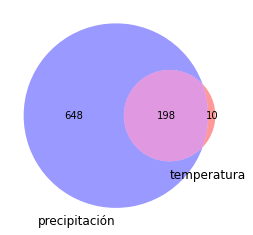

In [23]:
set1 = set(shp_join_gdf2['ID_x'][(shp_join_gdf2['met'].isin(['precipitación','precipitación y temperatura']))])
set2 = set(shp_join_gdf2['ID_x'][(shp_join_gdf2['met'].isin(['temperatura','precipitación y temperatura']))])
#set3 = set()

venn2([set1, set2], ('precipitación', 'temperatura'), ('blue', 'red') )

plt.show()

In [24]:
# Número de estaciones meteorlógicas por departamento
tbl_depto_met = pd.DataFrame(shp_join_gdf2.groupby(['DeNombre', 'met']).agg({'met': ['count']}).reset_index())
tbl_depto_met = pd.DataFrame({'DeNombre': tbl_depto_met.iloc[:,0], 'met': tbl_depto_met.iloc[:,1], 'count': tbl_depto_met.iloc[:,2]})
tbl_depto_met = tbl_depto_met.pivot_table('count', ['DeNombre'], 'met').fillna(0)
tbl_depto_met['total'] = tbl_depto_met['precipitación']+ tbl_depto_met['precipitación y temperatura']+tbl_depto_met['temperatura']
#tbl_depto_met
tbl_depto_met.sort_values('total', ascending = False).head(6)

met,precipitación,precipitación y temperatura,temperatura,total
DeNombre,,,,
Boyacá,67.0,18.0,0.0,85.0
Cundinamarca,65.0,16.0,3.0,84.0
Antioquia,46.0,14.0,1.0,61.0
Santander,45.0,16.0,0.0,61.0
Meta,38.0,7.0,0.0,45.0
Nariño,32.0,13.0,0.0,45.0


In [25]:
# convierte las columnas en filas de 'Fecha', y luego las filas 'ID' en columnas
pcp_col = pcp_col.drop('geometry', axis=1)
pcp_col = pcp_col.melt(id_vars = ['ID', 'X', 'Y'], var_name = 'Fecha', value_name = 'Valor').pivot_table('Valor', ['Fecha'], 'ID')
pcp_col.index = pd.to_datetime(pcp_col.index)
print(pcp_col.index.__class__)
print([pcp_col.shape, min(pcp_col.index), max(pcp_col.index)])
pcp_col.tail(5)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
[(469, 846), Timestamp('1981-01-01 00:00:00'), Timestamp('2020-01-01 00:00:00')]


ID,11010010,11020010,11020050,11030010,11030030,11030040,11035010,11035020,11040010,11045010,...,54020010,54020020,54020040,54020080,54025010,54085010,54090010,55010020,55015010,56015010
Fecha,,,,,,,,,,,,,,,,,,,,,
2019-09-01,1326.5,-999.0,-999.0,1291.0,-999.0,-999.0,-999.0,-999.0,435.0,721.3,...,1174.0,528.0,457.0,643.0,407.4,-999.0,678.0,702.0,-999.0,606.0
2019-10-01,933.1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,870.0,840.4,...,758.0,-999.0,-999.0,671.0,391.5,-999.0,-999.0,-999.0,-999.0,834.2
2019-11-01,500.8,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,706.0,...,798.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,468.5
2019-12-01,831.4,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,984.7,...,963.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,507.6
2020-01-01,629.1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,674.6,...,560.0,-999.0,-999.0,-999.0,152.5,-999.0,-999.0,-999.0,-999.0,331.1


In [26]:
# reemplaza valores negativos con el anterior, si el valor anterior o el siguiente es negativo reemplaza con None
#if pcp_col.iloc[i-1,j]<0 or pcp_col.iloc[min(i+1,pcp_col.shape[0]-1),j]<0 and sum(pcp_col.iloc[:,j]<0)>1:
for j in range(pcp_col.shape[1]):
    for i in range(pcp_col.shape[0]):
        if pcp_col.iloc[i,j]<0:
            if pcp_col.iloc[i-1,j]<0 or pcp_col.iloc[min(i+1,pcp_col.shape[0]-1),j]<0:
                pcp_col.iloc[i,j] = None
            else:
                pcp_col.iloc[i,j] = pcp_col.iloc[i-1,j]
        else: pcp_col.iloc[i,j] = pcp_col.iloc[i,j]

In [27]:
tmed_col = pd.read_excel('/home/fm/Downloads/tmed_col2.xlsx', sheet_name= 'Data')
tmed_col = tmed_col.pivot_table('obs_values', ['Date'], 'ID')
print([tmed_col.shape, min(tmed_col.index), max(tmed_col.index)])
tmed_col.tail(3)

[(474, 208), Timestamp('1981-01-01 00:00:00'), Timestamp('2020-06-01 00:00:00')]


ID,11045010,11115020,12015020,12015070,12045020,13075010,13075020,13085010,13085030,13085040,...,52045040,52055010,52055020,52055030,52055040,52055060,52055090,54015010,54025010,56015010
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-01,26.9,24.5,27.5,28.3,29.5,29.0,29.4,28.6,27.6,30.2,...,18.4,12.3,12.2,20.8,13.7,20.5,13.9,19.0,21.4,26.1
2020-05-01,27.0,-999.0,27.3,28.0,29.3,28.6,28.2,28.9,27.5,29.2,...,19.0,12.4,12.2,21.1,13.8,20.9,14.0,19.4,21.8,26.5
2020-06-01,26.5,-999.0,27.3,27.5,28.4,28.3,28.2,28.5,27.5,28.4,...,18.3,11.8,11.6,21.0,13.5,20.3,13.6,18.7,21.3,26.1


In [28]:
for j in range(tmed_col.shape[1]):
    for i in range(tmed_col.shape[0]):
        if tmed_col.iloc[i,j]<=0:
          if tmed_col.iloc[i-1,j]<0 or tmed_col.iloc[min(i+1,tmed_col.shape[0]-1),j]<0:
            tmed_col.iloc[i,j] = None
          else:
            tmed_col.iloc[i,j] = tmed_col.iloc[i-1,j]            
        else: tmed_col.iloc[i,j] = tmed_col.iloc[i,j]

In [29]:
pcp_nas = pd.DataFrame({'ID_x':pcp_col.columns,  'nas_pcp':[sum(pd.isna(pcp_col[j])) for j in pcp_col.columns]})
pcp_nas = pcp_nas[pcp_nas['nas_pcp']>0] 
pcp_nas.shape[0]/pcp_col.shape[1] # 52.71%
pcp_nas['ID_x'][pcp_nas['ID_x']==26095320.0]=26095230.0
pcp_nas['ID_x'][pcp_nas['ID_x']==52025090.0]=52025050.0
pcp_nas['ID_x'][pcp_nas['ID_x']==52055210.0]=52055040.0
print(pcp_nas['ID_x'])

1      11020010
2      11020050
3      11030010
4      11030030
5      11030040
         ...   
840    54025010
841    54085010
842    54090010
843    55010020
844    55015010
Name: ID_x, Length: 446, dtype: int64


In [30]:
tmed_nas = pd.DataFrame({'ID_x':tmed_col.columns,  'nas_tmed':[sum(pd.isna(tmed_col[j])) for j in tmed_col.columns]})
tmed_nas = tmed_nas[tmed_nas['nas_tmed']>0] 
tmed_nas.shape[0]/tmed_col.shape[1] # 37.98%
print(tmed_nas['ID_x'])

1      11115020
12     15015060
17     15075060
21     16025010
22     16025030
         ...   
195    52045010
201    52055030
202    52055040
205    54015010
206    54025010
Name: ID_x, Length: 79, dtype: int64


In [31]:
nas = pd.merge(pcp_nas, tmed_nas, how="outer", on="ID_x", indicator = True)
nas['met2'] = np.where(nas['_merge']=="both", "precipitación y temperatura", 
                       np.where(nas['_merge']== "left_only", "precipitación", "temperatura"))
nas.groupby('met2')['met2'].count()

met2
precipitación                  398
precipitación y temperatura     48
temperatura                     31
Name: met2, dtype: int64

In [32]:
nas2 = pd.merge(shp_join_gdf2, nas, how = "left", on="ID_x")
tbl_nas = pd.DataFrame(nas2.groupby(['DeNombre', 'met2']).agg({'met2': ['count']}).reset_index())
tbl_nas = pd.DataFrame({'DeNombre': tbl_nas.iloc[:,0], 'met2': tbl_nas.iloc[:,1], 'count': tbl_nas.iloc[:,2]})
tbl_nas = tbl_nas.pivot_table('count', ['DeNombre'], 'met2').fillna(0)
tbl_nas['total_nas'] = tbl_nas['precipitación']+ tbl_nas['precipitación y temperatura']+tbl_nas['temperatura']
tbl_nas = pd.merge(tbl_nas, tbl_depto_met['total'], how = "inner", left_index=True, right_index=True)
tbl_nas['porc'] = tbl_nas['total_nas']/tbl_nas['total']
tbl_nas['porc'].describe()

count    30.000000
mean      0.605828
std       0.241210
min       0.166667
25%       0.402381
50%       0.668074
75%       0.763529
max       1.000000
Name: porc, dtype: float64

In [33]:
shp_depto_4326_ = pd.merge(shp_depto_4326, tbl_nas['porc'], how="left", left_index=True, right_index=True)
shp_depto_4326_['porc'] = np.where(pd.isna(shp_depto_4326_['porc']), 0, shp_depto_4326_['porc'])

In [34]:
nas2 = nas2[~pd.isna(nas2['met2'])]
SAyP = shp_depto_4326_.query("Depto == 'San Andrés Providencia y Santa Catalina'")

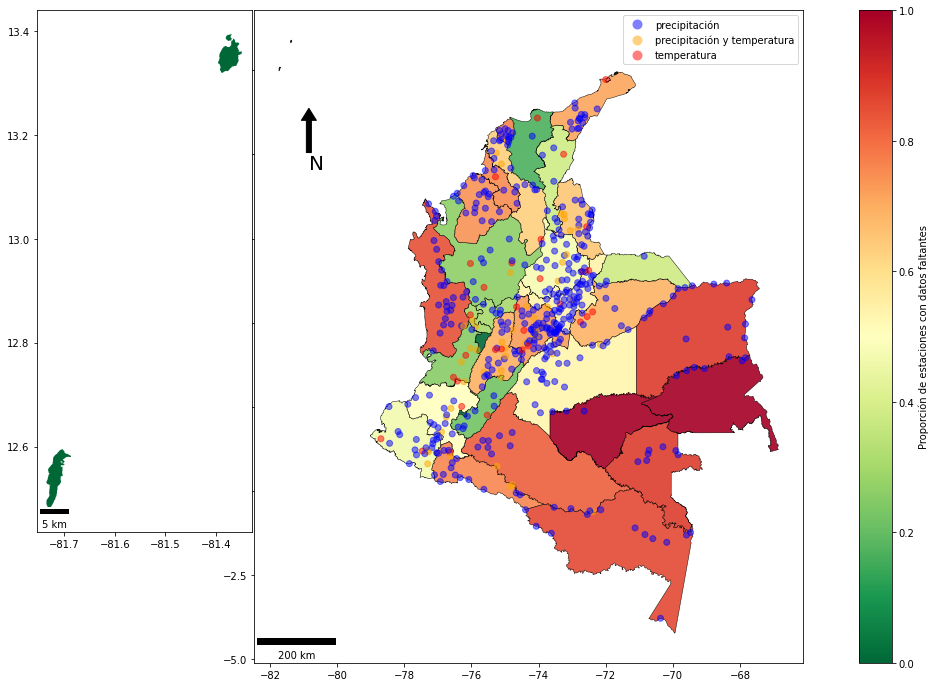

In [35]:
axis = shp_depto_4326_.plot("porc", legend = True,figsize = (20, 12), linewidth = 0.5, cmap='RdYlGn_r',alpha=0.9,
                            edgecolor='black',legend_kwds={'label': "Proporción de estaciones con datos faltantes",
                                        'orientation': "vertical"})

axis.add_artist(ScaleBar(distance_meters, location='lower left'))
axis.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
              arrowprops=dict(facecolor='black', width=5, headwidth=15),
              ha='left', va='bottom', fontsize=20,
              xycoords=axis.transAxes)
nas2.plot(ax = axis, column = 'met2', alpha = 0.5, legend = True, cmap=colors.ListedColormap(list(color_dict.values()))) 
#axis2 = SAyP['perimetro'].plot(color = "black",figsize = (20, 12), linewidth = 0.5)
#x_ins = inset_axes(axis, width="30%",  height="30%", loc = 2)
ins = axis.inset_axes([-0.6,0.2,0.8,0.8])
SAyP.plot(ax = ins, column = 'porc', linewidth = 0.5, cmap='RdYlGn_r')
ins.add_artist(ScaleBar(distance_meters, location='lower left'))
#SAyP['perimetro'].plot(color = "black",figsize = (20, 12), linewidth = 0.5)
plt.show()